In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [111]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
#Ignore annoying warning (from sklearn and seaborn)

In [112]:
train = pd.read_csv('train.csv')
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [113]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### Save and delete ID column

We don't want any coorelation with the ID column, we'll remove it and add it back in to create the submission file.

In [114]:
testid = test['Id']
test.drop('Id', axis = 1, inplace = True) 
trainid = train['Id']
train.drop('Id', axis = 1, inplace = True) 

#### Outliers

I'll use the same outliers function I used in the first assignment to evaluate the outliers!

In [115]:
def chkout(a,d):
    std_ = d[a].std()
    min_outlier_ = d[a].mean() - (std_ * 2)
    max_outlier_ = d[a].mean() + (std_ * 2)
    return (d[a].where(d[a]>=max_outlier_).count(), d[a].where(d[a]<=min_outlier_).count(), max_outlier_, min_outlier_)

#This will output how many values are max outliers and min outlier, and then 
#the values I'm using as cutoffs (2x the standard deviation)

chkout('SalePrice',train)

(63, 0, 339806.2016561842, 22036.19012463768)

Alright! So there are no values that are too low, but there are some that are too high. Let's look at them in a histrogram to see what the distribution of data looks like.

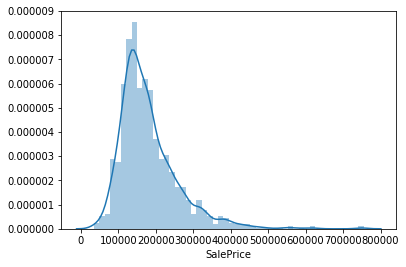

In [116]:
#Histogram with 50 bins
sns.distplot(train['SalePrice'], bins=50)

Ok, while our max value was '339,806', it seems they really taper off after '400,000'. That's where we'll drop the values.

In [117]:
train = train.drop(train.loc[train['SalePrice']>=400000].index)

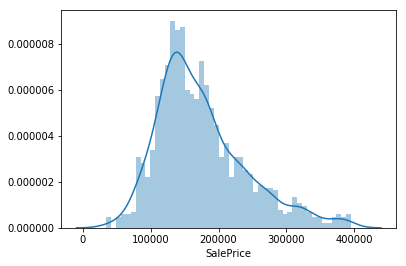

In [118]:
#Another look at the data, now without the dropped values
sns.distplot(train['SalePrice'], bins=50)

#### Coorelation

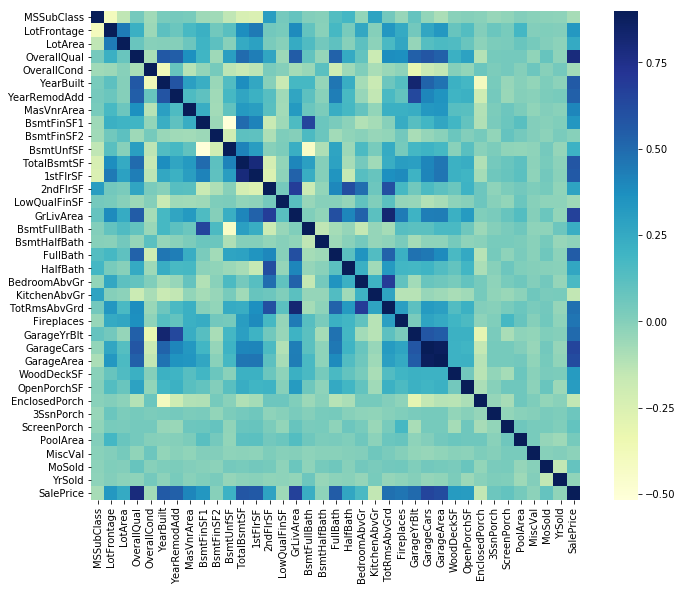

In [119]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap="YlGnBu")

Excellent! This gives us a good idea of what variables are going to matter most when determining 'SalePrice.' It looks like there are a lot of variables which don't have much impact (such as PoolArea, MoSold, BsmntFinSF2, etc.) This is important to note! We will want to pick regressions which can minimize or force certain variables to zero so as not to over fit or give unnecesary weight to worthless variables. I will mention this again a little later.

#### Deal with missing values

Our data is not complete, we will put it all together into the alldata data frame and clean it up a little.

In [120]:
ntrain = train.shape[0]
ntest = test.shape[0]
#Keep track of how many observarions were in 'test' and 'train'
target_train = train.SalePrice.values
#Copy the 'SalePrice' vector
alldata = pd.concat((train, test), sort = False).reset_index(drop=True)
#Put all our data together, and drop the 'SalePrice' variable. We only want variables that can predict 'SalePrice!'
alldata.drop(['SalePrice'], axis=1, inplace=True)

In [121]:
alldata.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2891.000000,2407.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2869.000000,2890.000000,2890.000000,...,2890.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000
mean,57.246627,69.056917,10088.715323,6.059841,5.567624,1971.042546,1984.074715,98.472290,434.887197,49.813841,...,469.470242,92.692840,46.941197,23.138706,2.627465,15.829125,2.081633,51.318229,6.218609,2007.793151
std,42.665039,23.128676,7820.843481,1.382622,1.115095,30.239653,20.898816,172.572752,448.462620,169.696928,...,213.192165,125.841512,67.264257,64.239537,25.308585,55.624170,34.328470,570.122084,2.715064,1.314321
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7439.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9382.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,364.500000,0.000000,...,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11466.000000,7.000000,6.000000,2000.000000,2004.000000,160.000000,727.000000,0.000000,...,576.000000,168.000000,68.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [122]:
#Create a table showing missing data
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum()/alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2882,0.996887
MiscFeature,2786,0.963680
Alley,2693,0.931512
Fence,2322,0.803182
FireplaceQu,1420,0.491180
LotFrontage,484,0.167416
GarageCond,159,0.054998
GarageQual,159,0.054998
GarageYrBlt,159,0.054998
GarageFinish,159,0.054998


For the majority of these, "NA" implies that the object isn't there or the value should be 0. Foe example, missing values in 'GarageCars' probably implies there is no garage. The following will replace those values with either 'None' or '0', depending on its type.

In [123]:
for columns in ('MasVnrType', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
                'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                'MiscFeature', 'Exterior1st', 'Exterior2nd'):
    alldata[columns] = alldata[columns].fillna('None')
    
for columns in ('MasVnrArea', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtHalfBath',
               'BsmtFinSF1', 'TotalBsmtSF', 'GarageCars', 'GarageArea', ):
    alldata[columns] = alldata[columns].fillna(0)
    

Many of the other missing values we will estimate with the most common value in that neighborhood, using the following function.

In [124]:
def replacemode(d,y):
    d[y] = d.groupby("Neighborhood")[y].transform(lambda x: x.fillna(x.mode()[0]))
    return print("done")


In [125]:
for columns in ('Electrical', 'MSZoning', 'SaleType', 'KitchenQual' ):
    replacemode(alldata, columns)
#replacemode(alldata, '')

done
done
done
done


For "LotFrontage" instead we will replace it with the mean of the neighborhood.

In [126]:
alldata["LotFrontage"] = alldata.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [127]:
alldata['Utilities'].describe()

count       2889
unique         2
top       AllPub
freq        2888
Name: Utilities, dtype: object

It seems that "Utilities" doesn't actually tell us much, we will drop it.

In [128]:
alldata = alldata.drop('Utilities', 1)

According to our description, NA in 'Functional' implies 'Typ'.

In [129]:
alldata['Functional'] = alldata['Functional'].fillna('Typ')

In [134]:
#Check to see if we got rid of all missing values
alldata.columns[alldata.isnull().any()]

Index([], dtype='object')

No more missing values! Next we'll set up our dummy variables and scale the data. These two steps are taken almost directly from the lectures.

In [135]:
alldata = pd.get_dummies(alldata)

In [136]:
scaler = StandardScaler()
scaler.fit(alldata)
scaled_train = scaler.transform(alldata)

Now we separate back out our training data...

In [137]:
train = alldata[:ntrain]
test = alldata[ntrain:]

In [138]:
#Make sure the data looks correct
train.tail()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1427,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1428,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,0,0,0,1,0,0,0,0,1,0
1429,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1430,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,...,0,0,0,1,0,0,0,0,1,0
1431,20,75.0,9937,5,6,1965,1965,0.0,830.0,290.0,...,0,0,0,1,0,0,0,0,1,0


#### Models

I decided to use a random forest and an Elastic Net model. What I like about these models is that they can force variables to go to zero or be approximatley worthless, which is good when we have a plethora of variables. I will create my Elastic Net with a lot of emphasis on the Lasso portion to help with this issue.

For comparison's sake, I will include a linear model as well.

In [139]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [140]:
X_train, X_test, y_train, y_test = train_test_split(train, target_train, test_size=0.2, random_state=42)
#Split up my train data into more test and training data. I chose a test size of 0.2.

In [142]:
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(np.sqrt(-1*random_search.best_score_)))

Best Parameters: {'eta0': 0.001}
Best Negative MSE: 1.513445307561278e+16


As expected, even the best MSE is still pretty terrible.

Let's see how our Elastic Net does!

In [143]:
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predictions))))
print("Test MSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predictions))))
print(clf.alpha_)
print(clf.l1_ratio_)

Train MSE: 21500.68809571741
Test MSE: 23059.72470973512
0.1
0.7


Alright! Significantly better! We can also observe what the best alpha and l1 ratios were.


Now, Random Forest. I worked with Random Forest modeling in a previous class, and loved its ability to create accurate predictions. In fact, it is one of the few machine learning methods that has been proven to be unbiased given assumptions similar to those we make OLS models! Let's see how she does.

In [58]:
param_dist = {"n_estimators": [100], "max_depth": [10, 25, 40, 50], "min_samples_split": [10, 20, 50], "max_features": [10, 25, 40, 50],
               "min_impurity_decrease": [.1, .2, .5], "max_leaf_nodes": [10, 25, 40, 50], 
               "bootstrap": ['True']}

#Again, testing different hyperparameters. We will be testing different amounts of depths, impurities (similar to the cost function),
#features, and nodes.
rfregressor = RandomForestRegressor()
rfgridsearch = GridSearchCV(rfregressor, param_grid=param_dist, scoring='neg_mean_squared_error', n_jobs=-1)
rfgridsearch.fit(X_train,y_train)
best_params=rfgridsearch.best_params_

In [59]:
print(best_params)

{'bootstrap': 'True', 'max_depth': 25, 'max_features': 50, 'max_leaf_nodes': 50, 'min_impurity_decrease': 0.2, 'min_samples_split': 10, 'n_estimators': 100}


In [67]:
rf1reg = RandomForestRegressor(n_estimators = best_params['n_estimators'], max_depth = best_params['max_depth'], min_samples_split= best_params['min_samples_split'],
                              max_features= best_params['max_features'], min_impurity_decrease = best_params['min_impurity_decrease'],
                              max_leaf_nodes = best_params['max_leaf_nodes'], bootstrap = best_params['bootstrap'], n_jobs=-1)


rf1reg.fit(X_train, y_train)
train_predictions = rf1reg.predict(X_train)
test_predictions = rf1reg.predict(X_test)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test,test_predictions)
print("Train MSE: {}".format(np.sqrt(train_mse)))
print("Test MSE: {}".format(np.sqrt(test_mse)))

Train MSE: 18293.879405936783
Test MSE: 25334.813011679023


Looks like it ran pretty well!

#### Submission

In [82]:
#We'll create our results using half Random Forest and half Elastic Net
results = rf1reg.predict(test)*.5 + clf.predict(test)*.5 

In [83]:
sub = pd.DataFrame()
sub['Id'] = testid
sub['SalePrice'] = results
sub.head()

,Id,SalePrice
0,1461,117192.437882
1,1462,152505.254202
2,1463,177000.923096
3,1464,193426.977929
4,1465,195094.213247


In [84]:
sub.to_csv('submission.csv',index=False)

I used some of the same data cleaning methods as this kernel: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Also big thanks to Robert Wagner for helping with some of the Random Forest coding!.